# Plotting
> Plot the result of CF explanations.

In [ ]:
#| default_exp plots

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2
from ipynb_path import *
import warnings
# warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
#| export
from __future__ import annotations
from relax.import_essentials import *
import seaborn as sns
import matplotlib.pyplot as plt
from relax.evaluate import Explanation
from relax.data import TabularDataModule

In [ ]:
#| export
def _process_exp(
    x: jnp.DeviceArray, # Dim: (N, k)
    cf: jnp.DeviceArray, # Dim: (N, k)
    pred_fn: Callable, # Predictive function
    return_valid: bool = False # Return only valid `x`, `cf`, `y_cf` or not
): # Return `x`, `cf`, `y_cf`
    """Process valid data."""
    
    assert x.shape == cf.shape
    assert len(x.shape) > 1

    y_cf = pred_fn(cf).round()
    
    if return_valid:
        y_x = pred_fn(x).round()
        idx = (y_x == y_cf).reshape(-1)
        x, cf, y_cf = x[idx], cf[idx], y_cf[idx]
    return x, cf, y_cf

In [ ]:
#| hide
pred_fn = lambda x: x
x = jnp.zeros((5, 1))
cf = jnp.ones((5, 1))

x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid=False)
assert x.shape == cf.shape
assert x.shape == (5, 1)
assert y_cf.shape == (5, 1)

x = jnp.zeros((5, 1))
cf = jnp.ones((5, 1))
x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid=True)
assert x.shape == cf.shape
assert x.shape == (0, 1)
assert y_cf.shape == (0, 1)

x = jnp.zeros((5, 1))
cf = jnp.ones((5, 1))
x = x.at[1].set(1)
x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid=True)
assert x.shape == cf.shape
assert jnp.allclose(x, jnp.ones(1))
assert jnp.allclose(x, cf)
assert y_cf.shape == (1, 1)


In [ ]:
#| export
def _diff(
    x: jnp.DeviceArray, # Dim: (N, k)
    cf: jnp.DeviceArray, # Dim: (N, k)
    pred_fn: Callable, # Predictive function
    datamodule: TabularDataModule, # Data module
    return_valid: bool = False, # Return only valid `x`, `cf`, `y_cf` or not
    return_outcome_col: bool = True # Return outcome column or not
) -> Tuple[pd.DataFrame, pd.DataFrame]: # Return continuous and categorical differences
    """Calculate differences between `x` and `cf`"""
    
    x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid)
    # wrap to numpy.array
    x, cf, y_cf = map(np.asarray, (x, cf, y_cf))
    x_inv, cf_inv = map(datamodule.inverse_transform, [x, cf], [y_cf, y_cf])
    cat_idx = datamodule.cat_idx
    cont_diff = pd.DataFrame(
        data=cf[:, :cat_idx] - x[:, :cat_idx],
        columns=datamodule._configs.continous_cols
    ) 
    cat_diff = (~cf_inv.iloc[:, cat_idx:-1].eq(x_inv.iloc[:, cat_idx:-1])).astype(float)
    if return_outcome_col:
        return pd.concat([cont_diff, cf_inv.iloc[:, -1:]], axis=1), \
            pd.concat([cat_diff, cf_inv.iloc[:, -1:]], axis=1)
    else:
        return cont_diff, cat_diff


In [ ]:
#| exporti
def _swarmplot(
    cont_diff: pd.DataFrame, ax
):
    target_col = cont_diff.columns[-1]
    cont_diff = cont_diff.melt(
        id_vars=[target_col], value_name='Difference', var_name='Features'
    )
    sns.stripplot(
        y="Features",
        x="Difference",
        data=cont_diff,
        hue=target_col,
        alpha=0.5,
        size=5,
        jitter=0.3,
        ax=ax
    ).set(title="Summary Plot for Continuous Features")
    return ax

In [ ]:
#| exporti
def _stripplot(
    cat_diff: pd.DataFrame, ax
):
    target_col = cat_diff.columns[-1]
    cat_diff = cat_diff.melt(
        id_vars=[target_col], value_name='Difference', var_name='Features'
    )
    # add noise for clear display 
    jitter = 0.3
    delta = np.random.uniform(-jitter/2, jitter/2, len(cat_diff['Difference']))
    cat_diff['Difference'] = cat_diff['Difference'].values + delta
    sns.stripplot(
        y="Features",
        x="Difference",
        data=cat_diff,
        hue=target_col,
        alpha=0.5,
        size=5,
        jitter=0.3,
        ax=ax
    ).set(title="Summary Plot for Categorical Features")
    return ax

In [ ]:
#| export
def summary_plot(
    exp: Explanation, # Explanations to visualize
    sample_frac: float = 1.0, # Sample part of data for visualization
    only_valid: bool = False, # Use only valid data
    figsize=(15, 7) # Figure size
) -> plt.Figure:
    """Globally visualize generated explanations."""

    cont, cat = _diff(
        exp.X, exp.cfs, exp.pred_fn, exp.data_module, only_valid
    )
    fig, (ax1, ax2) = plt.subplots(1, 2)
    _swarmplot(cont.sample(frac=sample_frac), ax1)
    _stripplot(cat.sample(frac=sample_frac), ax2)

    # Resize to create overlap
    fig.set_size_inches(figsize[0], figsize[1])
    plt.subplots_adjust(wspace=.5)

    return fig

In [ ]:
#| exporti
def _barplot(
    diff: pd.Series, ax
):
    sns.barplot(
        x=diff.values, y=diff.index, ax=ax
    ).set(title="Counterfactual Explanations for An Individual Sample")

In [ ]:
#| export
def individual_plot(
    exp: Explanation, # Explanations to visualize
    idx: int, # Index for visualization
    figsize=(15, 7) # Figure plot
) -> plt.Figure:
    """Locally visualize individual explanations."""

    cont, cat = _diff(
        exp.X[idx, :].reshape(1, -1), exp.cfs[idx, :].reshape(1, -1), 
        exp.pred_fn, exp.data_module, return_outcome_col=False
    )
    diff = pd.concat([cont, cat], axis=1)

    # plot individual differences
    fig, ax = plt.subplots()
    _barplot(diff.iloc[0], ax)
    fig.set_size_inches(figsize[0], figsize[1])
    return fig

## Example

We first use `VanillaCF` to generate `Explanation`.

In [ ]:
from relax.utils import load_json
from relax.module import PredictiveTrainingModule
from relax.trainer import train_model
from relax.evaluate import generate_cf_explanations
from relax.methods import VanillaCF

In [ ]:
#| output: false
# load configs
configs = load_json('assets/configs/data_configs/adult.json')
m_configs = configs['mlp_configs']
data_configs = configs['data_configs']
t_configs = dict(n_epochs=10, batch_size=256)

# load data and model
dm = TabularDataModule(data_configs)
model = PredictiveTrainingModule(m_configs)

# train predictive models
params, opt_state = train_model(model, dm, t_configs)
pred_fn = lambda x, params, prng_key: model.forward(params, prng_key, x, is_training=False)

# generate explanations
exp = generate_cf_explanations(
    VanillaCF(), dm, pred_fn, 
    pred_fn_args=dict(params=params, prng_key=random.PRNGKey(0))
)

/Users/chuck/opt/anaconda3/envs/relax/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chuck/opt/anaconda3/envs/relax/lib/python3.8/site-packages/relax/_ckpt_manager.py:47: UserWarning: `monitor_metrics` is not specified in `CheckpointManager`. No checkpoints will be stored.
  warnings.warn(
100%|██████████| 1000/1000 [00:05<00:00, 176.17it/s]


In [ ]:
#| hide
cont_diff, cat_diff = _diff(exp.X[:5], exp.cfs[:5], exp.pred_fn, exp.data_module, return_outcome_col=True)
assert len(cont_diff) == len(cat_diff)
assert len(cont_diff) == 5
assert len(cont_diff.columns) + len(cat_diff.columns) == len(exp.data_module.data.columns) + 1

cont_diff, cat_diff = _diff(exp.X[:5], exp.cfs[:5], exp.pred_fn, exp.data_module, return_outcome_col=False)
assert len(cont_diff) == len(cat_diff)
assert len(cont_diff) == 5
assert len(cont_diff.columns) + len(cat_diff.columns) == len(exp.data_module.data.columns) - 1


To visualize individual explanation: 

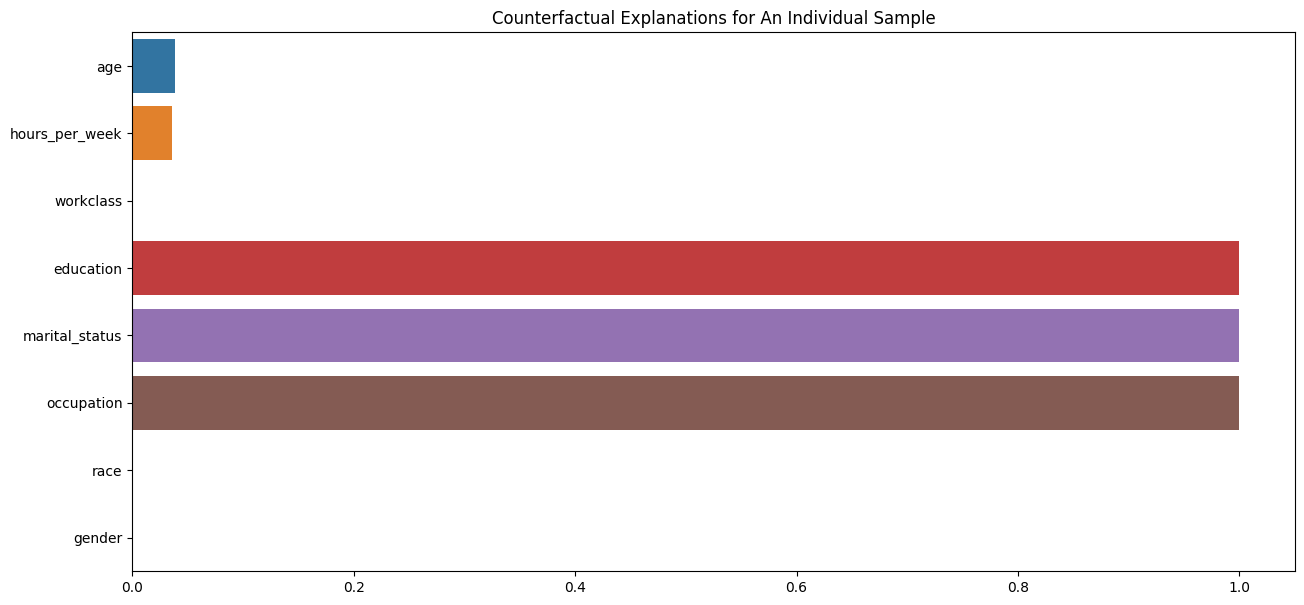

In [ ]:
# this visualize the differences between `exp.X[0]` and `exp.cfs[0]`
fig = individual_plot(exp, idx=0)

To analyze the entire explanation distribution:

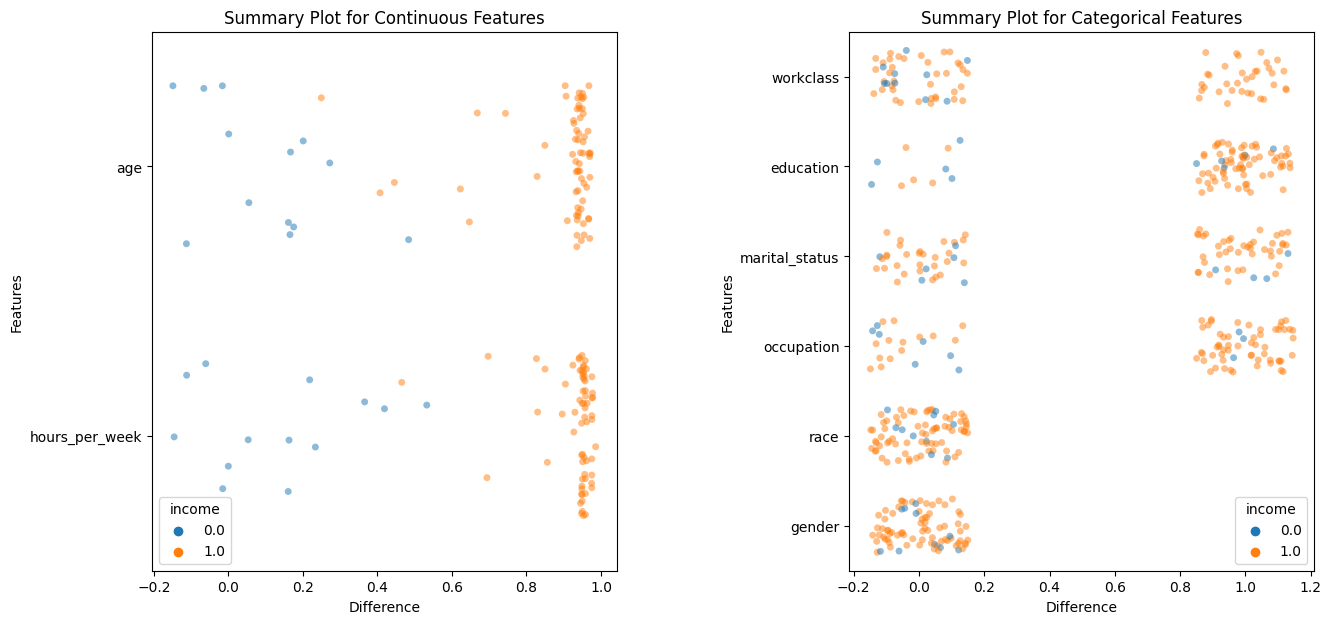

In [ ]:
fig = summary_plot(exp, sample_frac=0.01)